# Introduction

With coronavirus and quarantine, companies in at-home fitness like Peloton experienced explosive growth. I was one of these people who invested in a Peloton bike and became a part of their online community. A common post is expression of excitement for their bike delivery coming soon and asking the group:  **“What class and/or instructor should I take first?”**

A big part in selecting classes comes down to perceived difficulty based on the user. There isn’t a UI feature to filter by this, but at a class level you can see the difficulty level based on user ratings they are prompted for after completing a ride. Additionally, there is the capability to search class by a song or artist based on what is on the playlist to pull classes with the type of music the person wants to ride to.

### This notebook contains the winning Decision Tree model that predicts the perceived difficulty of the class based on Peloton class data including the Spotify features of the artists and tracks from the class playlists.

<br>The goal metric was the F1 score (both micro-averaged and macro-averaged were tested for/considered)** as a False Positive like a class is labeled easy, but it isn't and a False Negative of a class is not labeled easy, but it is are of equal risk. They both impact a riders first experience with the bike. This is especially important for confidence building and creating a routine in fitness. If a class labelled easy is too difficult, the rider will less likely be back as completing the ride was not an achievable outcome.

# Notebook Summary

#### Models
Note: Models used for analysis italicized

**Initiating**
- [Creating Dataset](#CD)

**Modeling**
- [Manual Preprocessing](#MP)
- [Winning Decision Tree and Viz](#WDT)

**Analysis**
- [Class Duration](#ClassDur)

**Conclusion**
- [Recommendations](#REC)
- [Future Work](#FW)



**Results**

The final Decision Tree resulted in an accuracy and f1 score of 67-69%. From the modeling perspective, this is a net positive result as it is an improvement from the baseline of a 50% accuracy guessing Intermediate difficulty as it is the majority class.

The Intermediate class has highest f1 and recall scores, which makes sense as Intermediate is the majority class.
- Recall: What proportion of Intermediate classes were identified correctly?

The Beginner class has the highest precision.
- Precision: What proportion of classes the model identified as "Beginner" difficulty were actually correct?

When applied to the business context, it is also positive result as Peloton is introducing cycling and spin to those who were not cyclists before ([Source](https://www.nbcnews.com/better/lifestyle/fitness-brands-mirror-fight-camp-peloton-want-you-quit-gym-ncna1064376)). This would signal that the majority of people's first ride would be in the Beginner or Intermediate space; thus it is acceptable for Advanced class difficulty to not be a labelling priority in comparison.

In [273]:
# Basics 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import math
import operator 
import matplotlib.pyplot as plt
%matplotlib inline

# Importing dfs with heavy processing
import pickle

# Imports Modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, plot_confusion_matrix

# Feat Imp
from yellowbrick.model_selection import FeatureImportances

# Decision Tree Plotting
import graphviz
from sklearn import tree
import pylab

In [274]:
# Just in case other pickle files available
# Opening pickle files
# Use classId where you can as key for merging
base_clean_df = pd.read_pickle("../../data/pickled_dfs/base_clean_df.pkl")
artist_df = pd.read_pickle("../../data/pickled_dfs/artist_df.pkl")
artist_id_class_count = pd.read_pickle("../../data/pickled_dfs/larger_spot_artist_id_class_count.pkl")  # has artist features
songs_df = pd.read_pickle("../../data/pickled_dfs/songs_df.pkl")
song_class_count_df = pd.read_pickle("../../data/pickled_dfs/song_class_count_df.pkl")
song_class_count_df.rename(columns={'Artist':'Song'}, inplace=True) # Quick clean rename column
class_type_reorg_df = pd.read_pickle("../../data/pickled_dfs/class_type_reorg_df.pkl")
new_class_types_with_artists = pd.read_pickle("../../data/pickled_dfs/new_class_types_with_artists.pkl")
master_song_df = pd.read_pickle("../../data/pickled_dfs/master_song_df.pkl") # has song features
# artist_id_class_count has 186 rows with 0LyfQWJT6nXafLPZqxe9Of - it means Various Artists
# and 40 errors

## Creating base dataset<a id="CD"></a>
The steps below get the data to match Data V6 from previous notebooks where instructors and class categories were condensed to account for those with low counts.

In [275]:
df = pd.read_pickle("../../data/pickled_dfs/master_first_classes_with_stats.pkl")
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0,3.611225,Music
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0,5.703883,Intervals
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5,3.729600,Beginner
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0,3.624000,Music
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0,3.800000,Music


In [276]:
df['classDifficulty'].describe()

count    6983.000000
mean        7.858991
std         0.778619
min         4.272800
25%         7.554450
50%         8.047400
75%         8.378250
max         9.653600
Name: classDifficulty, dtype: float64

In [277]:
def label_class_diff_cat(classDifficulty):
    '''
    Label Class Difficulty Beginner, Intermediate, or Advanced for each Peloton class based on classDifficulty rating
    
    Inputs:
    - Peloton classDifficulty value - float value between 0 and 10
    
    Outputs:
    - Class Difficulty label Beginner, Intermediate, or Advanced
    '''   
    if classDifficulty < 7.55:
        return 'Beginner'
    if classDifficulty >= 7.55 and classDifficulty < 8.37:
        return 'Intermediate'
    if classDifficulty >= 8.37:
        return 'Advanced'

In [278]:
# Create classDifficulty_cat for categories of Class Difficulty for classification target
df['classDifficulty_cat'] = df['classDifficulty'].apply(label_class_diff_cat)

In [279]:
# Create numerical target, can use classDifficulty_cat for labels
df['classDifficulty_num'] = df['classDifficulty_cat'].map({'Beginner': 0,
                                                           'Intermediate': 1,
                                                           'Advanced': 2})

In [280]:
# Group instructors will low class count
other_instructors = ['Irène Scholz', 'Erik Jäger', 'Christian Vande Velde', 'Cliff Dwenger',
                     'Alex & Tunde', 'Mayla Wedekind', 'Ally & Emma', 'Cycling Instructors 2019']

df['instructorName'] = df['instructorName'].replace(other_instructors, 'Other')

In [281]:
# Recategorize low count classes
# Create Other category for those <50 
# Put Groove Cody classes into Theme - not a music genre or year, but a programmatic type class like XOXO
df['classCategory'] = df['classCategory'].replace({'Heart Rate Zone' : 'Other',
                                                   'Live DJ' : 'Other',
                                                   'Pro Cyclist' : 'Other',
                                                   'Groove': 'Theme'})                                               

## Modeling

In [282]:
def eval_model(estimator, X_train, X_test, y_train, y_test, target_names, average):
    '''
    Evaluation function to show accuracy, f1 score, mean 3-fold cross-validation 
    for both the train and test set, then shows confusion matrix for the test set
    
    Inputs:
    - estimator: model
    - X_train, y_train, X_test, y_test - train and test set results from train_test_split 
    - target_names - class labels to be used in classification report and confusion matrix
    - average - for setting f1 score details (micro, macro)
    
    Outputs:
    - Classification report
    - Training set Accuracy score
    - Training set F1 score with average (micro, macro) consideration
    - Test set Accuracy score
    - Test set F1 score with average (micro, macro) consideration
    - Test set F1 score Mean 3-Fold Cross Validation score
    - Confusion Matrix
    '''   
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print report
    print(classification_report(y_test, test_preds, target_names=target_names))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds, average=average)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds, average=average)}")
    print(f"F1 Score Mean Cross Val 3-Fold: {np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring=(f'f1_{average}')))}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, display_labels = target_names, values_format='')
    plt.show()

In [283]:
# Define X and y 
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classDifficulty_num',
                     'classOriginalAirdate', 'classType', 'classLength', 'instructorBio', 'classEquipment', 
                     'classUrl', 'classRating', 'classRatingCount', 'classDescription', 'classSongs', 
                     'classArtists','className', 'classLocation'])

#y is the target created previously
y = df['classDifficulty_num']

### Manual Preprocessing for Modeling<a id="MP"></a>

Purposefully not in pipeline for easier data access in analysis

In [284]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [285]:
# Copy df for manipulation
scaled_features = df.copy()

In [286]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [287]:
# Copy df for manipulation
ohe_features = df.copy()

In [288]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [289]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine

In [290]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [291]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Other', 'classCategory_Power Zone', 'classCategory_Theme', 'instructorName_Alex Toussaint', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christine D'Ercole', 'instructorName_Cody Rigsby', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Olivia Amato', 'instructorName_Other', 'instructorName_Robin Arzón',
       'instr

In [292]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_num
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Winning Decision Tree Model<a id="WDT"></a>

In [293]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_num'], axis=1)
y = preprocessed['classDifficulty_num']

In [294]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [295]:
# Instantiate
tuned_dt_ent = DecisionTreeClassifier(criterion = 'entropy',
                                      max_depth = 9, 
                                      max_features = 14,
                                      min_samples_leaf = 1, 
                                      min_samples_split = 25,
                                      random_state=42)

tuned_dt_ent.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

    Beginner       0.83      0.54      0.66       426
Intermediate       0.66      0.81      0.73       861
    Advanced       0.67      0.60      0.63       459

    accuracy                           0.69      1746
   macro avg       0.72      0.65      0.67      1746
weighted avg       0.70      0.69      0.68      1746

Train Scores
------------
Accuracy: 0.7196868436127554
F1 Score: 0.7196868436127553
--------------------
Test Scores
-----------
Accuracy: 0.6890034364261168
F1 Score: 0.6890034364261168
F1 Score Mean Cross Val 3-Fold: 0.6849357406915083


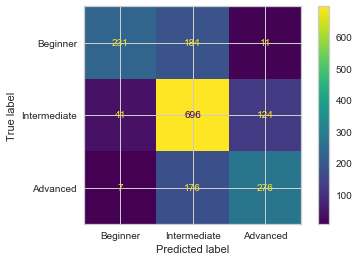

In [296]:
# F1 Micro
eval_model(tuned_dt_ent, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# less overfit by another 1%
# accuracy/f1 only down 0.002

              precision    recall  f1-score   support

    Beginner       0.83      0.54      0.66       426
Intermediate       0.66      0.81      0.73       861
    Advanced       0.67      0.60      0.63       459

    accuracy                           0.69      1746
   macro avg       0.72      0.65      0.67      1746
weighted avg       0.70      0.69      0.68      1746

Train Scores
------------
Accuracy: 0.7196868436127554
F1 Score: 0.7063475753551763
--------------------
Test Scores
-----------
Accuracy: 0.6890034364261168
F1 Score: 0.6719788309487916
F1 Score Mean Cross Val 3-Fold: 0.6707176813375108


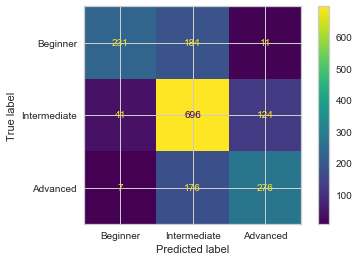

In [297]:
# F1 Macro
eval_model(tuned_dt_ent, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='macro')
# accuracy/f1 down 0.02 from micro

### Visualization

In [298]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

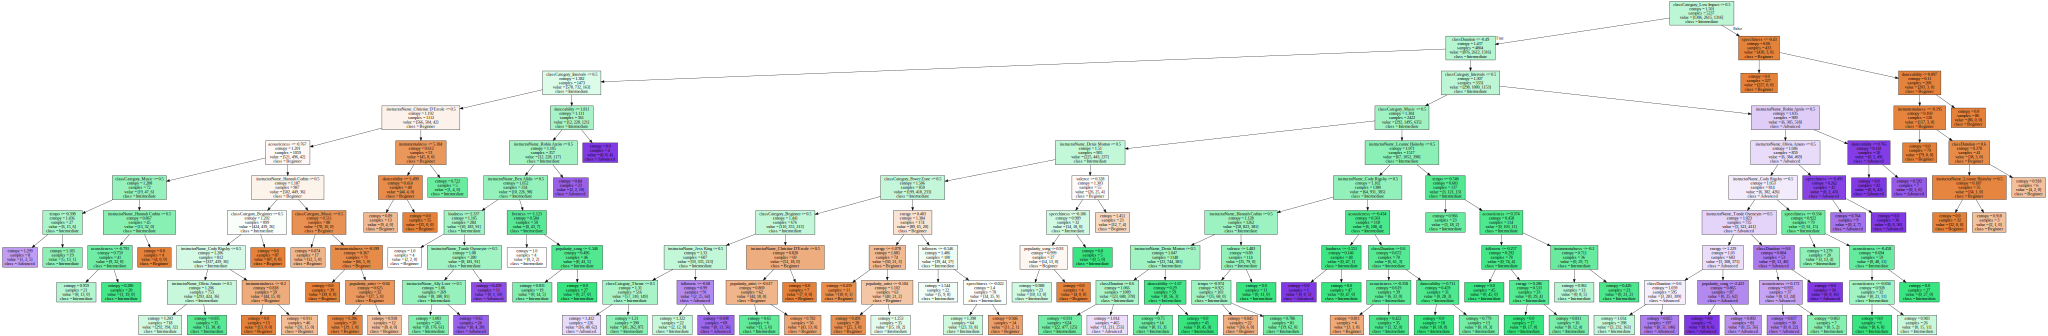

In [299]:
# DOT data
dot_data = tree.export_graphviz(tuned_dt_ent, out_file=None, 
                                feature_names=fn,  
                                class_names=cn,
                                max_depth = 10,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 

# save graph
pel_tree = graph.render(filename='../../images/man_pel_tree')

# show graph
graph

# Source:  https://mljar.com/blog/visualize-decision-tree/

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


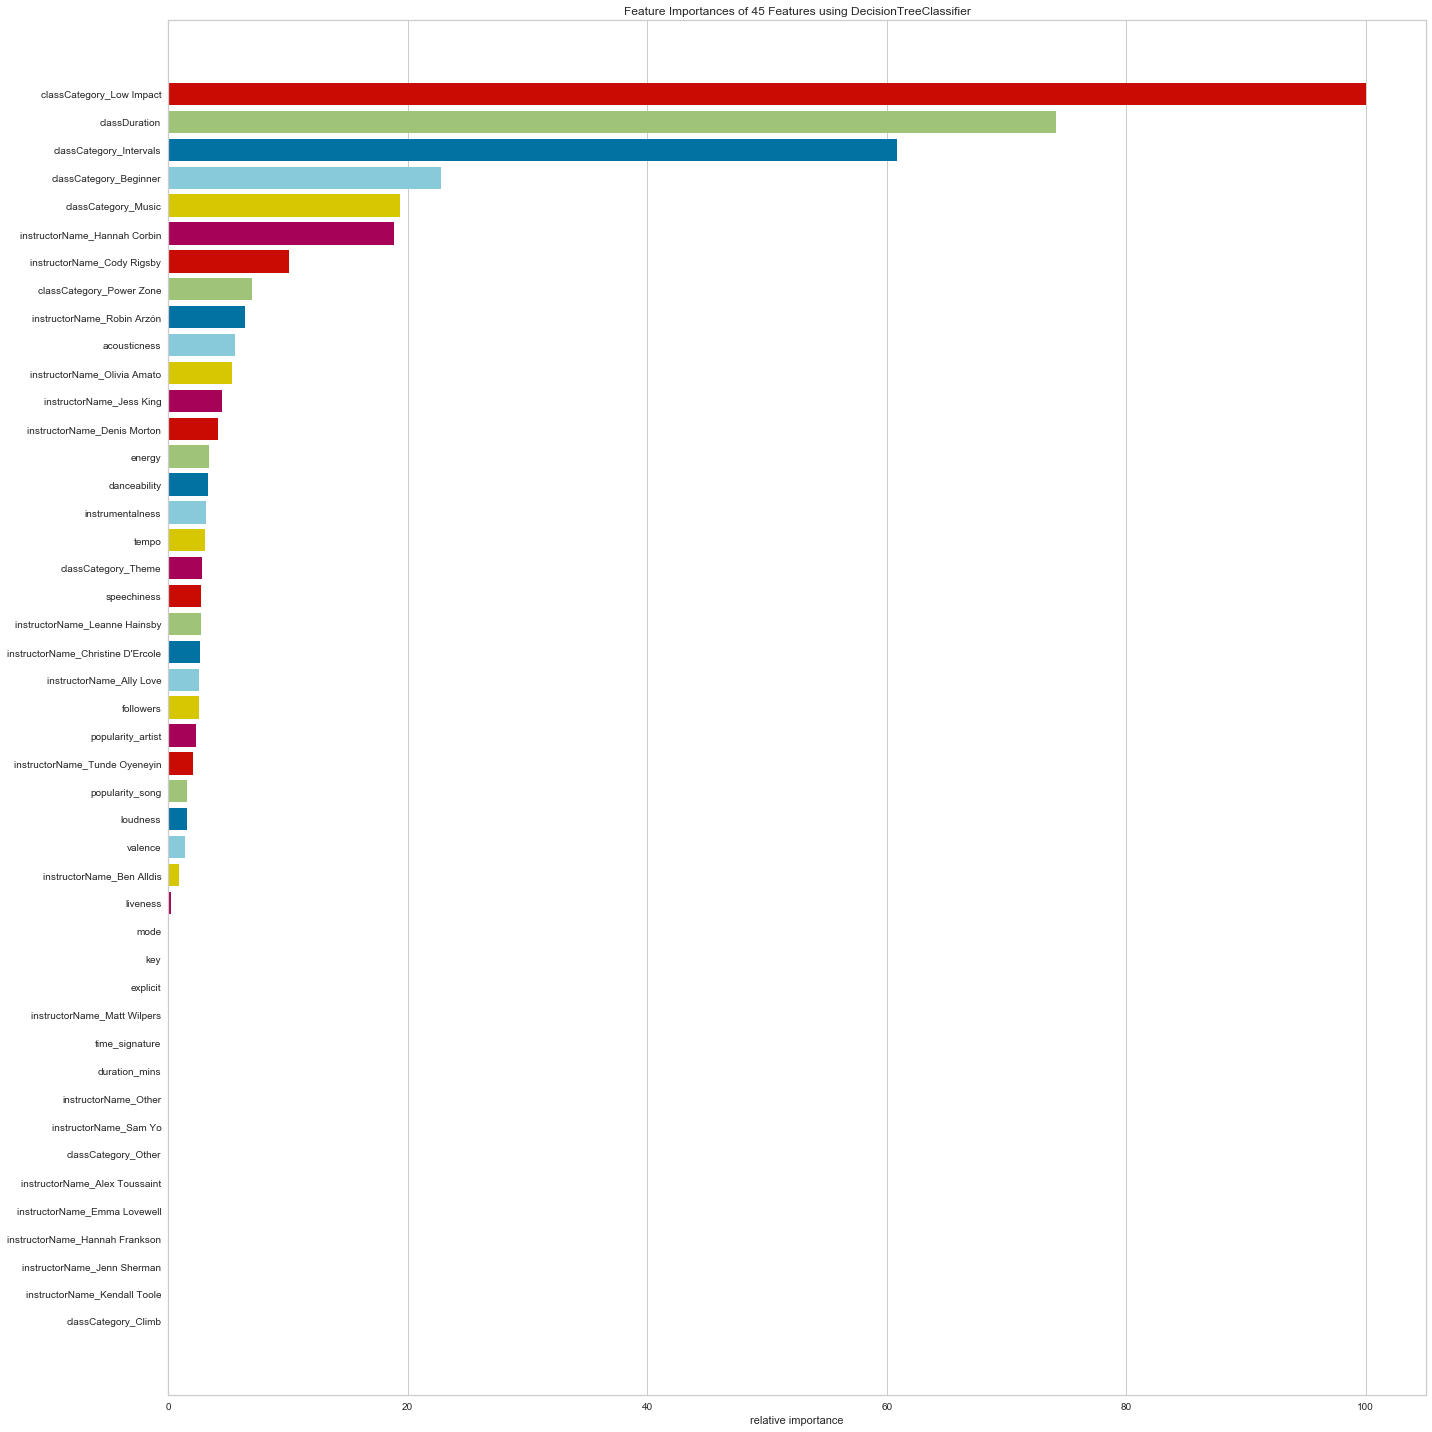

In [300]:
# Feature importance plotting 
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_dt_ent)
viz.fit(X, y)
viz.show()

#### Learnings from tree and analysis below
1. If class is Low Impact, it is Beginner.


2. If a class is Intervals, difficulty will depend on the duration, instructor and/or the music.


3. If the class is < 30 mins it will more likely be Beginner/Intermediate, but could be Intermediate or Advanced if high danceability (> 1.811) and a Robin class. 
    - Next layer towards Beginner class is if Christine is teaching a non-Intervals class < 30 mins. 
        - Her playlists are more instrumental, so the decision below her is instrumentalness <=5.184. If true, Beginner.



4. If classDuration is 30 mins or more will lean towards Advanced. Tree goes:
    - If class is > 30 mins, then still intermediate
    - Is the class an Intervals class? If yes, it will be Advanced
        - Next driver is if instructor is Robin? If yes, then next driver is it the instructor is Olivia? Then Cody, then Tunde. 
        - If not Robin, music danceability <= 0.765 (if TRUE, more likely Advanced -- but Advanced either way)
    - If class is not Intervals, then if classCategory is Music, the class difficulty will lean Intermediate (rare that these classes are Advanced)

## Analysis

### Class Duration <a id="ClassDur"></a>

In [301]:
# Tree split on classDuration <= -0.49. If False, goes to Intervals then Instructors
# Check out if false subset to see what durations fall under this scaled value for Advanced
classdur_subset = preprocessed[preprocessed['classDuration'] > -0.49]

In [302]:
# preview new df
classdur_subset

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_num
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,-0.053947,0.970625,-0.26515,-0.876639,0.406461,-0.189652,1.362923,0.690826,-0.159273,-0.141504,-0.199490,-0.596037,-0.114890,0.646298,0.034566,1.790008,1.403223,0.143843,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
10,-0.053947,0.482915,-0.26515,0.590270,1.091312,-0.665177,0.063991,0.690826,-0.596627,-0.371231,-0.199488,0.713650,1.257800,-0.986481,0.034566,-0.715689,-1.226493,-0.230368,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
11,1.254071,-1.630497,-0.26515,0.409913,-0.145509,0.285873,-0.770397,0.690826,-0.395149,-0.749109,-0.144853,1.023839,-0.428449,0.643766,0.034566,-0.545181,0.120435,-0.632829,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,-0.053947,1.377050,-0.26515,-1.032949,-1.607207,0.285873,-3.294293,0.690826,-0.837417,0.935871,-0.198272,-1.056151,1.557422,0.542478,0.034566,-0.547912,-0.392680,1.886750,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6976,1.254071,-0.329936,-0.26515,-1.525926,1.357075,0.285873,1.257013,0.690826,-0.513087,-0.768331,-0.199569,-0.372012,-0.672327,0.807216,0.034566,-0.474217,-0.136123,-1.049309,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6978,-0.053947,0.401630,-0.26515,-0.551995,-1.310778,-1.140702,-1.171620,0.690826,-0.166644,0.523299,-0.199616,-1.238818,0.561003,-0.017547,0.034566,-0.616071,-1.547190,0.161727,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6981,1.254071,-0.208009,-0.26515,-0.515923,-0.109733,0.761399,-1.422384,0.690826,-0.780905,-0.615024,-0.177325,1.833778,0.738686,-1.056321,0.034566,-0.634988,-0.649238,0.638450,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [303]:
# create variable for original df classDuration Series
og_classdur = df['classDuration']

In [304]:
# Rename for merging
og_classdur.rename('og_classDur', inplace=True)

0       20
1       20
2       30
3       30
4       20
        ..
6978    30
6979    20
6980    20
6981    45
6982    45
Name: og_classDur, Length: 6983, dtype: int64

In [305]:
# Merge original information to subset of scaled classDuration values
ClassDuration_traceback = classdur_subset.merge(og_classdur, how='left', 
                                                left_index=True, right_index=True)

In [306]:
# filter down columns for comparison
only_classdurs = ClassDuration_traceback[['classDuration', 'og_classDur']]

In [307]:
# overview of original classDurations included in subset
only_classdurs['og_classDur'].value_counts()

30    2750
45    1740
60     161
90       7
75       6
Name: og_classDur, dtype: int64

In [700]:
class_durations_pie = pd.DataFrame(only_classdurs['og_classDur'].value_counts())

In [702]:
class_durations_pie

,og_classDur
30,2750
45,1740
60,161
90,7
75,6


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until


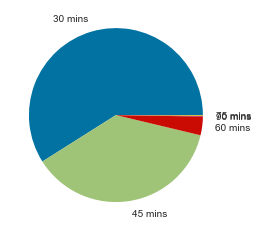

In [713]:
# plt.figure(figsize=10)
plt.pie(class_durations_pie, labels = ['30 mins', '45 mins', '60 mins', '90 mins', '75 mins'],
       labeldistance=1.15)
plt.show()

In [308]:
# Compare with all original ClassDurations. Can see all 30 min+ classes are included in the classDuration > -0.49
df['classDuration'].value_counts()

30    2750
20    1749
45    1740
15     318
10     252
60     161
90       7
75       6
Name: og_classDur, dtype: int64

#### Learning: 
If classDuration is 30 mins or more will lean towards Advanced. Tree goes:
- If class is > 30 mins... still intermediate
- Is the class an Intervals class? If yes, it will be Advanced
    - Next driver is if instructor is Robin. If yes, then music danceability <= 0.765 (if TRUE, more likely Advanced)
    - If not Robin, then is it Olivia? If yes, then music speechiness <= -0.495 (if FALSE, more likely Advanced)

NOTE: Next step, do same class count as with artists

### Top Artists and Songs in Difficulties

In [542]:
def diff_top_artists_and_songs(processed_data, orig_data):
    """
    Function takes in processed and original data, then merges this data with artist and song features
    to produce two DataFrames:
    1. Top artists
    2. Top songs 
    Both DataFrames include relative features, class counts, and class percentages (class_per) to 
    know of the number of classes where these artist or songs appear in the given data subset, and
    what percentage these counts makes up versus the full dataset of classes.
    -------
    Prerequisites:
     - Import pickled data sets:
        - artist_df - pd.read_pickle("../../data/pickled_dfs/artist_df.pkl")
        - artist_id_class_count (has artist features) - pd.read_pickle("../../data/pickled_dfs/larger_spot_artist_id_class_count.pkl")
        - songs_df - pd.read_pickle("../../data/pickled_dfs/songs_df.pkl")
        - master_song_df (has song features)- pd.read_pickle("../../data/pickled_dfs/master_song_df.pkl") 
    -------
    Input: 
    - processed_data - processed data used in winning model, now being used for analysis.
    This should be a subset of data and was built for the purpose to analyze different difficulties, 
    but can be used on any subset.
    - orig_data - original data set, pre-processing (pre scalers, OHE, etc)
    -------
    Output:
    - artists_with_feats - DataFrame of top artists with relative features
    - songs_with_feates - DataFrame of top songs with relative features
    """
    # artist_with_feats df creation
    # Merge processed and original data
    traceback = processed_data.merge(orig_data, how='left',left_index=True, right_index=True)
    
    # Create master subset
    orig_data_sub = traceback[['classId', 'classSongs', 'classArtists', 'popularity_song_y', 'explicit_y', 
                           'danceability_y', 'energy_y', 'key_y', 'loudness_y', 'mode_y', 'speechiness_y',
                           'acousticness_y', 'instrumentalness_y', 'liveness_y', 'valence_y', 'tempo_y', 
                           'time_signature_y', 'followers_y', 'popularity_artist_y', 'duration_mins_y']]
    
    
    # Merge with artist_df to get artists for original data
    orig_data_sub_with_artists = orig_data_sub.merge(artist_df, how='left', on='classId')
    
    # Create list of artists
    artist_list = list(orig_data_sub_with_artists.columns[21:])
    
    # Create artist dictionary using for loop to grab column name as the dict key and sum of each column as dict value
    artist_total_dict = {}

    for artist in artist_list:
        artist_total_dict[artist] = orig_data_sub_with_artists[artist].sum()

    sorted_artist_count_dict = dict(sorted(artist_total_dict.items(), key=operator.itemgetter(1),reverse=True))

    artist_count_df = pd.DataFrame.from_dict(sorted_artist_count_dict, orient='index').reset_index()
    artist_count_df.rename(columns={"index": "artist", 0: "classCount"}, inplace = True)
    artist_count_df = artist_count_df[artist_count_df['classCount'] > 0]
    
    # Create new df of artists and counts with their artist features
    artists_with_feats = artist_count_df.merge(artist_id_class_count, how='inner', on='artist')

    # Calculate % of classes this artist is used in that difficulty
    artists_with_feats.insert(4, 'class_per', round(artists_with_feats['classCount']/artists_with_feats['total Class Count'], 2))
    
    # Filter down DataFrame to artists with classCount in 99th percentile
    artists_with_feats = artists_with_feats[artists_with_feats['classCount'] > (np.percentile(artists_with_feats['classCount'], 95))]
    
    # Sort by class_per to get to artists that have the highest percentage of their playlist
    # inclusion within this subset
    artists_with_feats = artists_with_feats.sort_values(by='class_per', ascending=False)
    
# ----------------------------------
    # songs df creation
    orig_data_sub_with_songs = orig_data_sub.merge(songs_df, how='left', on='classId')

    # Create list of song
    song_list = list(orig_data_sub_with_songs.columns[22:])

    # Create dictionary using for loop to grab column name as the dict key and sum of each column as dict value
    song_total_dict = {}

    for song in song_list:
        song_total_dict[song] = orig_data_sub_with_songs[song].sum()

    sorted_song_count_dict = dict(sorted(song_total_dict.items(), key=operator.itemgetter(1),reverse=True))

    song_count_df = pd.DataFrame.from_dict(sorted_song_count_dict, orient='index').reset_index()
    song_count_df.rename(columns={"index": "peloton_song_name", 0: "classCount"}, inplace = True)
    song_count_df = song_count_df[song_count_df['classCount'] > 0]

    # get what you need out of master song df to rematch up to song_count_df
    subset_master_songs = master_song_df[['peloton_song_name', 'song_id', 'Class Count', 'artist', 'artists', 'popularity', 'duration_ms', 'explicit', 'release_date', 
                                        'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                                        'instrumentalness', 'liveness', 'valence', 'tempo','time_signature']]
    
    # Create new df of songs and counts with their song features
    songs_with_feats = song_count_df.merge(subset_master_songs, how='left', on='peloton_song_name')

    # Calculate % of classes this song is used in that are in this subset
    songs_with_feats.insert(4, 'class_per', round(songs_with_feats['classCount']/songs_with_feats['Class Count'], 2))
    
    # Filter down DataFrame to songs with classCount in 99th percentile
    songs_with_feats = songs_with_feats[songs_with_feats['classCount'] > (np.percentile(songs_with_feats['classCount'], 95))]
    
    # Sort by class_per to get to songs that have the highest percentage of their playlist
    # inclusion within this subset
    songs_with_feats = songs_with_feats.sort_values(by='class_per', ascending=False)
    
    return artists_with_feats, songs_with_feats

### Beginner Classes (Total Labeled)

In [520]:
# Create data subset of beginner classes for analysis
beg_subset_all = preprocessed[preprocessed['classDifficulty_num'] == 0]

In [521]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
beg_top_artists_all, beg_top_songs_all = diff_top_artists_and_songs(beg_subset_all, df)

In [522]:
# Preview artists 
beg_top_artists_all

# OLD NOTES
# Gavin Degraw - 34%
# Kings of Leon - used more often, but less overall % at 15%
# Dave Matthews
# Maroon 5 and P!nk top class counts - but beginner classes don't make up much of 
# how many overall playlists they show up on

,artist,classCount,id,total Class Count,class_per,followers,popularity
21,Dave Matthews Band,64,2TI7qyDE0QfyOlnbtfDo7L,220,0.29,1504809.0,70.0
24,Alanis Morissette,56,6ogn9necmbUdCppmNnGOdi,258,0.22,1882996.0,71.0
5,Maroon 5,92,04gDigrS5kc9YWfZHwBETP,432,0.21,30291109.0,91.0
0,P!nk,163,1KCSPY1glIKqW2TotWuXOR,802,0.20,10740388.0,86.0
6,U2,88,51Blml2LZPmy7TTiAg47vQ,542,0.16,8157894.0,82.0
27,Beyoncé,55,6vWDO969PvNqNYHIOW5v0m,358,0.15,27048881.0,88.0
22,Coldplay,62,4gzpq5DPGxSnKTe4SA8HAU,417,0.15,29753797.0,89.0
28,Kelly Clarkson,52,3BmGtnKgCSGYIUhmivXKWX,347,0.15,7566980.0,78.0
31,Lenny Kravitz,50,5gznATMVO85ZcLTkE9ULU7,334,0.15,2215671.0,73.0
8,Ed Sheeran,85,6eUKZXaKkcviH0Ku9w2n3V,607,0.14,78900234.0,92.0


In [523]:
# Preview songs
beg_top_songs_all

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
21,Jackie and Wilson (Album Version),15,spotify:track:7mxNte0lD8HOLwLS4TvmdZ,21,0.71,The Karaoke Party Poppers,NaN,0,177863,False,2015-04-15,0.609,0.882,5,-12.306,1,0.0570,0.103000,0.17,0.0961,0.755,183.194,4
32,You Are the Best Thing,13,spotify:track:1jyddn36UN4tVsJGtaJfem,26,0.50,NaN,['Ray LaMontagne'],70,231840,0,2008-10-13,0.578,0.727,10,-4.872,1,0.0332,0.030400,1.99e-05,0.1720,0.885,170.593,4
52,Budapest,11,spotify:track:2ixsaeFioXJmMgkkbd4uj1,23,0.48,NaN,['George Ezra'],79,200733,0,2014-06-30,0.717,0.455,5,-8.303,1,0.0276,0.084600,0,0.1100,0.389,127.812,4
63,ABC,11,spotify:track:6D8kc7RO0rqBLSo2YPflJ5,25,0.44,NaN,['The Jackson 5'],67,174867,0,1970-05-08,0.572,0.786,8,-8.469,1,0.0642,0.519000,0.00093,0.1100,0.952,188.115,4
28,Who Knew,14,spotify:track:15joiMls8SpP1VtGivYh6i,35,0.40,NaN,['Eminem'],58,227760,1,2000-05-23,0.855,0.596,7,-4.147,1,0.3070,0.135000,0,0.1390,0.793,100.894,4
12,Walk Me Home,17,spotify:track:6jfEZdUJ2Yla6h7gTJgKuo,42,0.40,NaN,['P!nk'],71,177391,0,2019-04-25,0.652,0.453,1,-6.119,1,0.0445,0.051900,0,0.1790,0.432,88.038,3
40,Alright,12,spotify:track:5xC8uOesnn0udeXAYlAnoY,31,0.39,NaN,['Supergrass'],73,180880,0,1995-05-15,0.467,0.958,4,-4.808,0,0.0775,0.000479,0.199,0.2990,0.701,145.920,4
37,Drops of Jupiter,12,spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA,31,0.39,Train,NaN,78,259933,False,2001-03-27,0.481,0.638,0,-5.862,1,0.0276,0.153000,0,0.1540,0.497,79.064,4
17,Viva La Vida,16,spotify:track:1mea3bSkSGXuIRvnydlB5b,43,0.37,NaN,['Coldplay'],81,242373,0,2008-05-26,0.486,0.617,5,-7.115,0,0.0287,0.095400,3.23e-06,0.1090,0.417,138.015,4
5,I Want You Back,18,spotify:track:5LxvwujISqiB8vpRYv887S,49,0.37,NaN,['The Jackson 5'],77,176333,0,1969-12-18,0.469,0.538,8,-13.559,1,0.0571,0.305000,0.00012,0.3700,0.886,196.605,4


### Beginner Classes (Model Results - Low Impact Classes)

In [524]:
# Create data subset of beginner classes for analysis
beg_subset_lowim = preprocessed[(preprocessed['classCategory_Low Impact'] == 1)]

In [525]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
beg_top_artists_lowim, beg_top_songs_lowim = diff_top_artists_and_songs(beg_subset_lowim, df)

In [526]:
# Preview artists 
beg_top_artists_lowim

# OLD NOTES
# Gavin Degraw - 34%
# Kings of Leon - used more often, but less overall % at 15%
# Dave Matthews
# Maroon 5 and P!nk top class counts - but beginner classes don't make up much of 
# how many overall playlists they show up on

,artist,classCount,id,total Class Count,class_per,followers,popularity
10,Gavin DeGraw,26,5DYAABs8rkY9VhwtENoQCz,76,0.34,1098820.0,68.0
13,Kings Of Leon,24,2qk9voo8llSGYcZ6xrBzKx,148,0.16,NaN,NaN
5,Kings of Leon,32,2qk9voo8llSGYcZ6xrBzKx,214,0.15,4672487.0,80.0
9,Dave Matthews Band,28,2TI7qyDE0QfyOlnbtfDo7L,220,0.13,1504809.0,70.0
1,Maroon 5,46,04gDigrS5kc9YWfZHwBETP,432,0.11,30291109.0,91.0
8,Hozier,31,2FXC3k01G6Gw61bmprjgqS,366,0.08,4602616.0,82.0
7,Coldplay,31,4gzpq5DPGxSnKTe4SA8HAU,417,0.07,29753797.0,89.0
0,P!nk,48,1KCSPY1glIKqW2TotWuXOR,802,0.06,10740388.0,86.0
4,Imagine Dragons,33,53XhwfbYqKCa1cC15pYq2q,531,0.06,33665795.0,89.0
3,Alicia Keys,34,3DiDSECUqqY1AuBP8qtaIa,629,0.05,8565325.0,82.0


In [527]:
# Preview songs
beg_top_songs_lowim

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
17,Cop Stop,8,spotify:track:2PZo1LXlOMAYGwr0pYn4mT,8,1.00,Gavin DeGraw,NaN,28,204226,False,2008-05-06,0.594,0.760,7,-5.508,1,0.0306,0.020000,0,0.0816,0.841,129.938,4
3,Jackie and Wilson (Album Version),12,spotify:track:7mxNte0lD8HOLwLS4TvmdZ,21,0.57,The Karaoke Party Poppers,NaN,0,177863,False,2015-04-15,0.609,0.882,5,-12.306,1,0.0570,0.103000,0.17,0.0961,0.755,183.194,4
4,You Are the Best Thing,12,spotify:track:1jyddn36UN4tVsJGtaJfem,26,0.46,NaN,['Ray LaMontagne'],70,231840,0,2008-10-13,0.578,0.727,10,-4.872,1,0.0332,0.030400,1.99e-05,0.1720,0.885,170.593,4
14,Budapest,9,spotify:track:2ixsaeFioXJmMgkkbd4uj1,23,0.39,NaN,['George Ezra'],79,200733,0,2014-06-30,0.717,0.455,5,-8.303,1,0.0276,0.084600,0,0.1100,0.389,127.812,4
5,Drops of Jupiter,11,spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA,31,0.35,Train,NaN,78,259933,False,2001-03-27,0.481,0.638,0,-5.862,1,0.0276,0.153000,0,0.1540,0.497,79.064,4
1,I Want You Back,15,spotify:track:5LxvwujISqiB8vpRYv887S,49,0.31,NaN,['The Jackson 5'],77,176333,0,1969-12-18,0.469,0.538,8,-13.559,1,0.0571,0.305000,0.00012,0.3700,0.886,196.605,4
0,Use Somebody,18,spotify:track:5VGlqQANWDKJFl0MBG3sg2,62,0.29,NaN,['Kings of Leon'],77,230760,0,2008-09-23,0.276,0.715,0,-5.356,1,0.0432,0.005520,0.000417,0.2010,0.173,137.028,4
8,Viva La Vida,10,spotify:track:1mea3bSkSGXuIRvnydlB5b,43,0.23,NaN,['Coldplay'],81,242373,0,2008-05-26,0.486,0.617,5,-7.115,0,0.0287,0.095400,3.23e-06,0.1090,0.417,138.015,4
19,Roll To Me,8,spotify:track:7LF0YY1gON8rBECsyEs0Wb,38,0.21,NaN,['Del Amitri'],60,132307,0,1995-01-01,0.567,0.821,6,-5.894,1,0.0371,0.418000,0,0.1080,0.895,150.106,4
9,Sweet Disposition,10,spotify:track:2PLi7OmleXPNBrGLon3sUy,52,0.19,NaN,['The Temper Trap'],71,234360,0,2009-08-10,0.542,0.813,2,-6.890,1,0.0429,0.076500,0.252,0.1160,0.305,129.090,4


### Advanced Classes (Total Labeled)

In [528]:
adv_subset_all = preprocessed[preprocessed['classDifficulty_num'] == 2]

In [529]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
adv_top_artists_all, adv_top_songs_all = diff_top_artists_and_songs(adv_subset_all, df)

In [530]:
adv_top_artists_all

,artist,classCount,id,total Class Count,class_per,followers,popularity
24,Guns N' Roses,102,3qm84nBOXUEQ2vnTfUTTFC,334,0.31,20214651.0,83.0
5,Rick Ross,169,1sBkRIssrMs1AbVkOJbc7a,546,0.31,4748156.0,84.0
32,DJ Snake,90,540vIaP2JwjQb9dm3aArA4,302,0.30,7310355.0,83.0
17,Skrillex,106,5he5w2lnU9x7JFhnwcekXX,355,0.30,7789284.0,80.0
35,DMX,88,1HwM5zlC5qNWhJtM00yXzG,299,0.29,2693147.0,83.0
8,Meek Mill,143,20sxb77xiYeusSH8cVdatc,503,0.28,4968247.0,81.0
19,Busta Rhymes,104,1YfEcTuGvBQ8xSD1f53UnK,386,0.27,1746216.0,76.0
16,Aerosmith,106,7Ey4PD4MYsKc5I2dolUwbH,390,0.27,10079991.0,80.0
21,Fall Out Boy,104,4UXqAaa6dQYAk18Lv7PEgX,385,0.27,8743699.0,83.0
37,Disclosure,85,6nS5roXSAGhTGr34W6n7Et,332,0.26,1908198.0,79.0


In [531]:
adv_top_songs_all

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
32,Football Fanatic,19,spotify:track:4DjkbfhdhfmzKNOUPtv9Js,19,1.00,Music Beyond,NaN,2,81994,False,2018-10-22,0.644,0.572,8,-5.806,1,0.0289,0.008550,0.916,0.5030,0.3480,120.090,4
61,The Longest Yard,16,spotify:track:0Fi5GPyXr7c2vxdw9rJ8xF,16,1.00,Various Artists,NaN,42,266106,True,2005-01-01,0.830,0.864,4,-4.595,1,0.2860,0.121000,0,0.2040,0.7110,125.011,4
29,Hustle Hard Remix - Album Version (Edited),20,None,24,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,Busta Rhymes & Lil Jon),17,None,22,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,Let's Go (feat. Yelawolf,17,spotify:track:19xSVTy7c5jBGmHHgVXNbg,22,0.77,Travis Barker,NaN,56,193080,True,2011,0.707,0.906,9,-5.871,1,0.2040,0.124000,0,0.2940,0.5480,150.032,4
51,Twista,17,None,23,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Bulls On Parade,22,spotify:track:0tZ3mElWcr74OOhKEiNz1x,35,0.63,NaN,['Rage Against The Machine'],75,229467,1,1996-04-16,0.412,0.919,5,-7.291,1,0.1840,0.012400,0.0601,0.4240,0.5720,166.367,4
69,I Can't Stop,15,spotify:track:03EuhmMsEHVFI9ytainStU,24,0.62,NaN,['Flux Pavilion'],60,303911,0,2010-10-11,0.513,0.775,0,-7.202,0,0.0304,0.000672,0.248,0.4090,0.2050,139.932,4
67,Addicted To A Memory,15,spotify:track:0xTGfdrWzJLKRD4U6hxSsg,26,0.58,Zedd,NaN,49,303160,False,2015-05-18,0.660,0.762,1,-4.939,0,0.0442,0.000983,0.0242,0.1450,0.0659,128.008,4
6,Rollin' (Air Raid Vehicle),27,spotify:track:3IV4swNduIRunHREK80owz,52,0.52,NaN,['Limp Bizkit'],75,213760,1,2000-10-17,0.603,0.933,1,-3.358,1,0.1710,0.005910,0,0.2060,0.7090,96.306,4


### Advanced Classes (Model Results - 30 Min+ Intervals Classes)

In [532]:
adv_subset_int = preprocessed[(preprocessed['classDuration'] > -0.49) &
                          (preprocessed['classCategory_Intervals'] == 1)]

In [533]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
adv_top_artists_int, adv_top_songs_int = diff_top_artists_and_songs(adv_subset_int, df)

In [534]:
# Preview artists
adv_top_artists_int

,artist,classCount,id,total Class Count,class_per,followers,popularity
17,John Newman,80,34v5MVKeQnIo0CWYMbbrPf,267,0.30,638402.0,71.0
21,DJ Snake,75,540vIaP2JwjQb9dm3aArA4,302,0.25,7310355.0,83.0
0,Calvin Harris,246,7CajNmpbOovFoOoasH2HaY,1012,0.24,21562562.0,87.0
24,Disclosure,74,6nS5roXSAGhTGr34W6n7Et,332,0.22,1908198.0,79.0
19,Skrillex,79,5he5w2lnU9x7JFhnwcekXX,355,0.22,7789284.0,80.0
11,Avicii,103,1vCWHaC5f2uS3yhpwWbIA6,501,0.21,19536186.0,85.0
15,Diplo,87,5fMUXHkw8R8eOP2RNVYEZX,437,0.20,2376451.0,87.0
5,David Guetta,138,1Cs0zKBU1kc0i8ypK3B9ai,743,0.19,22429621.0,90.0
25,Tiësto,72,2o5jDhtHVPhrJdv3cEQ99Z,410,0.18,5527032.0,87.0
16,The Chainsmokers,85,69GGBxA162lTqCwzJG5jLp,472,0.18,17734996.0,85.0


In [535]:
# Preview songs
adv_top_songs_int

# OLD NOTES
# Class Count % top songs:
## Champion - Kanye West
## Messiah (Dirty South Remix) - I See MONSTAS 
## Money - ??
## Feel the Love (feat. John Newman) - Rudimental
## Habits (Stay High) (The Chainsmokers Extended) - Tove Lo

# Class Count top songs:
## Habits (Stay High) (The Chainsmokers Extended) - Tove Lo
## Messiah (Dirty South Remix) - I See MONSTAS 
## Levels (Skrillex Remix) - Avicii
## Open Season (Gryffin Remix) - Josef Salvat
## Pompeii (Remix) - Bastille

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
4,Habits (Stay High) (The Chainsmokers Extended ...,19,spotify:track:7lxKUx67JrEoxjayHCb0Xr,28,0.68,Tove Lo,NaN,47,294253,False,2014-03-03,0.684,0.772,10,-5.976,1,0.0356,0.002480,0.00403,0.0894,0.0418,128.025,4
1,Messiah (Dirty South Remix),23,spotify:track:4ocOSkLYp68DFrmPuRMvyA,44,0.52,I See MONSTAS,NaN,38,245624,False,2013-01-01,0.553,0.896,0,-5.222,0,0.0429,0.044300,0.333,0.0822,0.3360,128.005,4
49,Wake Me Up - EDX Miami Sunset Remix,12,spotify:track:6vQ0VbsRRFOYVmjAMM8c2a,24,0.50,NaN,['Avicii'],53,392812,0,2013-01-01,0.717,0.924,11,-4.377,0,0.0824,0.005180,0.0473,0.3620,0.6820,127.997,4
11,Levels (Skrillex Remix),16,spotify:track:5f6igUw1asUL4AGXSvgTW8,32,0.50,Avicii,NaN,58,281146,False,2011-12-19,0.615,0.910,5,-2.825,0,0.0762,0.007610,0.0067,0.1600,0.3460,140.000,4
25,Blame (R3HAB Trap Remix) (feat. John Newman),14,spotify:track:0wRaAh1Km76Blq4qMJjjvN,29,0.48,Calvin Harris,NaN,40,212093,False,2014-11-10,0.614,0.911,0,-4.102,0,0.0443,0.029300,0.000486,0.1350,0.1750,141.941,4
26,The Hills (RL Grime Remix),14,spotify:track:6SNUuxeg0NWXSEkFirAkAM,30,0.47,The Weeknd,NaN,51,271066,False,2015-11-06,0.572,0.897,0,-2.464,0,0.0433,0.112000,0.244,0.1570,0.4380,139.996,4
21,Flashing Lights,15,spotify:track:31I3Rt1bPa2LrE74DdNizO,33,0.45,NaN,"['Kanye West', 'Dwele']",78,237507,1,2007-09-11,0.639,0.628,6,-7.578,0,0.0399,0.038100,0,0.3860,0.4300,90.482,4
15,Pompeii (Remix),16,spotify:track:5o1TaTsFtDddxLa2BKw29y,40,0.40,Bastille,NaN,43,216687,False,2013-01-01,0.567,0.868,9,-2.327,1,0.0859,0.031400,0,0.1000,0.6680,127.545,4
8,Open Season (Gryffin Remix),17,spotify:track:6tl2UhS1qsjGpmBXzGgXm2,42,0.40,Josef Salvat,NaN,42,240000,False,2015-09-04,0.644,0.905,6,-4.324,0,0.0541,0.353000,0.0845,0.0821,0.5680,99.973,4
27,Do Or Die (Afrojack vs. THIRTY SECONDS TO MARS...,14,spotify:track:2hr7myxuDCoXsKyVfh4ue0,38,0.37,Afrojack,NaN,53,278174,False,2014-01-01,0.575,0.890,2,-3.169,1,0.0416,0.034000,3.23e-06,0.0470,0.2060,128.041,4


### Intermediate Classes

In [609]:
inter_subset_all = preprocessed[preprocessed['classDifficulty_num'] == 1]

In [610]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
inter_top_artists_all, inter_top_songs_all = diff_top_artists_and_songs(inter_subset_all, df)

In [611]:
inter_top_artists_all

,artist,classCount,id,total Class Count,class_per,followers,popularity
238,Take That,38,1XgFuvRd7r5g0h844A5ZUQ,66,0.58,979482.0,68.0
229,Whitesnake,39,3UbyYnvNIT5DFXU4WgiGpP,67,0.58,1963119.0,69.0
253,Foreigner,36,6IRouO5mvvfcyxtPDKMYFN,66,0.55,1948134.0,73.0
47,Little Mix,114,3e7awlrlDSwF3iM0WBjGMp,226,0.50,8958639.0,84.0
112,Bryan Adams,64,3Z02hBLubJxuFJfhacLSDc,129,0.50,2068570.0,79.0
48,Backstreet Boys,113,5rSXSAkZ67PYJSvpUpkOr7,229,0.49,3795212.0,79.0
213,Toto,40,2nbTrndWzGHdI3jDqCmTrj,82,0.49,1562.0,28.0
137,The Who,54,67ea9eGLXYMsO2eYQRui3w,113,0.48,3907800.0,74.0
165,Fifth Harmony,47,1l8Fu6IkuTP0U5QetQJ5Xt,97,0.48,12505767.0,75.0
176,Stormzy,45,2SrSdSvpminqmStGELCSNd,98,0.46,2232326.0,78.0


In [612]:
inter_top_songs_all

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
172,Black Magic,16,spotify:track:4cJhBmeJ7KiBeuy7oxRnZ3,17,0.94,NaN,['Slayer'],54,243360,0,1983,0.148,0.908,9,-7.336,1,0.1170,0.000005,0.614,0.0723,0.0707,93.888,4
384,La Isla Bonita,11,spotify:track:6r8k1vznHrzlEKYxL4dZEe,13,0.85,NaN,['Madonna'],72,242320,0,1986-06-30,0.725,0.612,1,-10.706,0,0.0372,0.302000,1.63e-05,0.0548,0.9650,99.978,4
475,There You Go,10,spotify:track:3A3kg1SK2gpHNPZJmXpfTv,12,0.83,NaN,['Johnny Cash'],28,135737,0,1958-11-13,0.778,0.727,10,-11.815,1,0.0542,0.827000,0.0179,0.1410,0.9300,97.884,4
442,Eternal Flame,11,spotify:track:5g3ZD7PmrEQlQZKDW91yGG,14,0.79,NaN,['The Bangles'],64,235667,0,1988-07-17,0.521,0.233,7,-13.683,1,0.0254,0.640000,0,0.2450,0.4090,78.927,3
374,"Knock on Wood (7"" Edit)",11,spotify:track:7vMRj40Rw8PPgZiDcbyUdj,14,0.79,Amii Stewart,NaN,46,227733,False,2016-11-18,0.691,0.873,2,-6.349,1,0.1840,0.000457,0.000582,0.1180,0.6670,139.384,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Heartbeat,14,spotify:track:6iQz54AGEoITB0wgFi3zfz,89,0.16,NaN,['Wham!'],43,283667,0,1984-10-23,0.546,0.552,2,-12.265,1,0.0276,0.160000,0,0.1690,0.8220,134.806,4
138,Hallelujah,18,spotify:track:1IvHVfTXdkwsF9mYNn5nNg,111,0.16,NaN,['Hubert Fol'],0,322133,0,1947,0.519,0.718,8,-12.337,1,0.0406,0.808000,0.0615,0.1950,0.8380,146.555,4
248,Closer,14,spotify:track:5mc6EyF1OIEOhAkD0Gg9Lc,97,0.14,NaN,['Nine Inch Nails'],61,373307,1,1994-03-08,0.546,0.724,10,-8.639,0,0.0427,0.000273,0.667,0.1330,0.5860,89.991,4
250,Diplo & Labrinth),14,None,107,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [614]:
inter_top_artists_all['popularity'].describe()

count    247.000000
mean      77.538462
std       11.906373
min        0.000000
25%       72.000000
50%       79.000000
75%       84.000000
max      100.000000
Name: popularity, dtype: float64

In [616]:
twenty_five = np.nanpercentile(inter_top_artists_all['popularity'], 25)
seventy_five = np.nanpercentile(inter_top_artists_all['popularity'], 75)

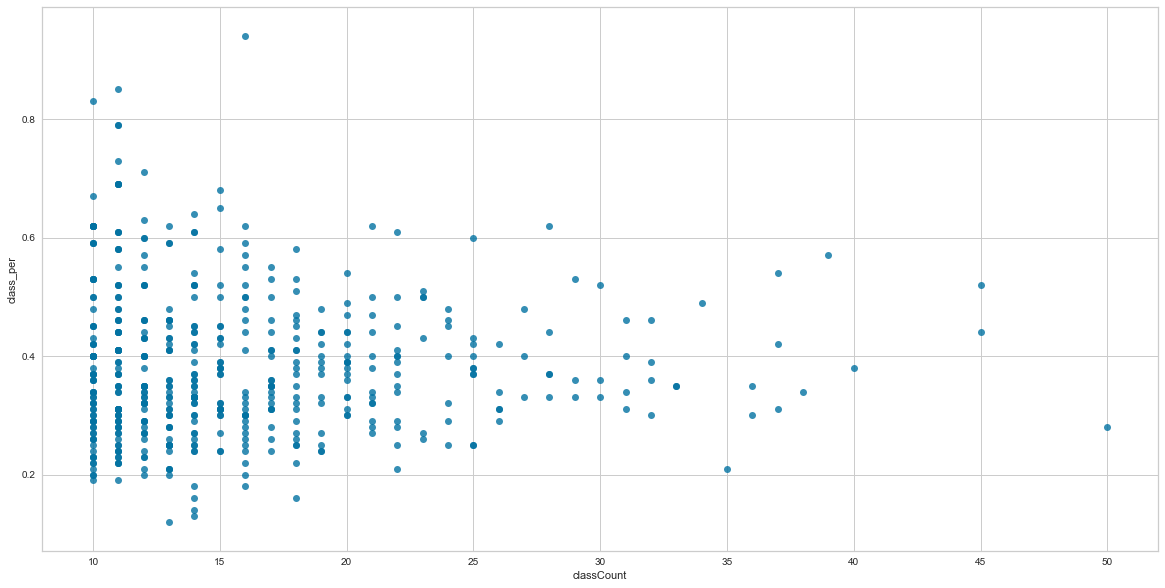

In [613]:
import seaborn as sns

plt.figure(figsize=(20,10))
 
# # use the function regplot to make a scatterplot
# sns.regplot(x=inter_top_songs_all['classCount'], y=inter_top_songs_all['class_per'])
 
# make a scatterplot without regression fit
ax = sns.regplot(x=inter_top_songs_all['classCount'], y=inter_top_songs_all['class_per'], 
                 fit_reg=False)

plt.show()

In [655]:
inter_top_artists_all['artistpop_cat'] = ""

for row in inter_top_artists_all.index:
    if inter_top_artists_all['popularity'][row] < twenty_five:
        inter_top_artists_all['artistpop_cat'][row] = 'Low'
    if inter_top_artists_all['popularity'][row] >= twenty_five and inter_top_artists_all['popularity'][row] < seventy_five:
        inter_top_artists_all['artistpop_cat'][row] = 'Medium'
    if inter_top_artists_all['popularity'][row] >= seventy_five:
        inter_top_artists_all['artistpop_cat'][row] = 'High'

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [656]:
inter_top_artists_all['artistpop_cat'].value_counts()

Medium    127
High       65
Low        55
           11
Name: artistpop_cat, dtype: int64

In [684]:
def plot_scatter(data, x, y, hue, legend, artist_or_song, subset_title):
    plt.figure(figsize=(20,10))
 
    sns.scatterplot(data= data, x= x, y= y, hue= hue, legend= legend)


    plt.title((f'{artist_or_song} Class Count vs Class Percentage in {subset_title}'), fontsize=20, fontweight="bold")
    plt.xlabel((f'{artist_or_song} Class Count'), fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel((f'{artist_or_song} Class Percentage'), fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

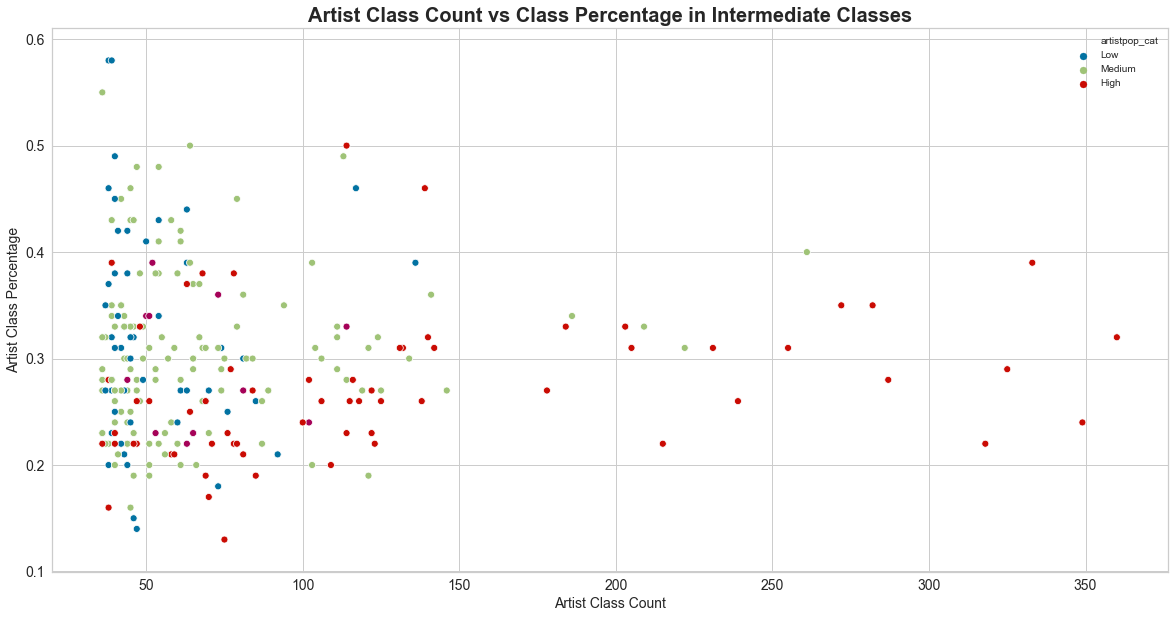

In [685]:
plot_scatter(inter_top_artists_all, x="classCount", y="class_per", 
             hue='artistpop_cat', legend='brief',
             artist_or_song='Artist', subset_title='Intermediate Classes')

In [677]:
twenty_five = np.nanpercentile(inter_top_artists_all['followers'], 25)
seventy_five = np.nanpercentile(inter_top_artists_all['followers'], 75)

In [678]:
inter_top_artists_all['followers_cat'] = ""

for row in inter_top_artists_all.index:
    if inter_top_artists_all['followers'][row] < twenty_five:
        inter_top_artists_all['followers_cat'][row] = 'Low'
    if inter_top_artists_all['followers'][row] >= twenty_five and inter_top_artists_all['followers'][row] < seventy_five:
        inter_top_artists_all['followers_cat'][row] = 'Medium'
    if inter_top_artists_all['followers'][row] >= seventy_five:
        inter_top_artists_all['followers_cat'][row] = 'High'

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [679]:
inter_top_artists_all['followers_cat'].value_counts()

Medium    123
High       62
Low        62
           11
Name: followers_cat, dtype: int64

In [682]:
def plot_scatter(data, x, y, hue, legend, artist_or_song, subset_title):
    plt.figure(figsize=(20,10))
 
    sns.scatterplot(data= data, x= x, y= y, hue= hue, legend= legend)


    plt.title((f'{artist_or_song} Class Count vs Class Percentage in {subset_title}'), fontsize=20, fontweight="bold")
    plt.xlabel((f'{artist_or_song} Class Count'), fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel((f'{artist_or_song} Class Percentage'), fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

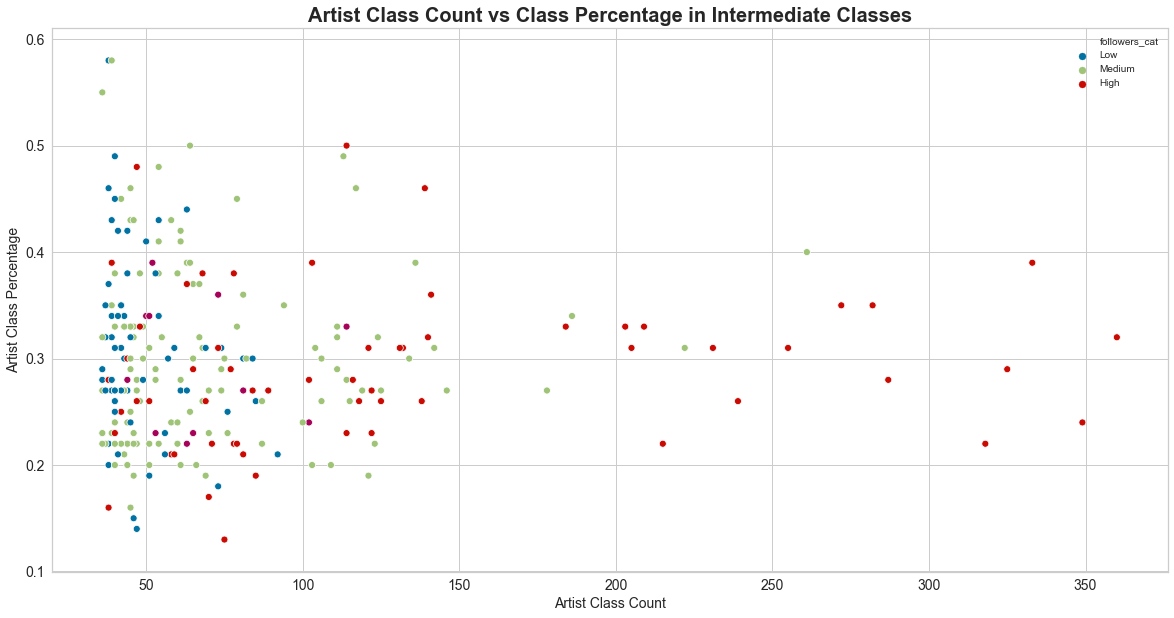

In [683]:
plot_scatter(inter_top_artists_all, x="classCount", y="class_per", 
             hue='followers_cat', legend='brief',
             artist_or_song='Artist', subset_title='Intermediate Classes')